In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

In [2]:
artist_info = pd.read_csv('artist_info_extended.csv')
display(artist_info.head())
df = pd.read_csv('spotify_songs.csv')
display(df.head())

,track_id,num_artists,artist_names,primary_artist,avg_artist_popularity,max_artist_popularity,min_artist_popularity,total_artist_followers,avg_artist_followers,max_artist_followers,artist_genres
0,29hVeHD64920MFf2oO6TFB,1,Lucky Luke,Lucky Luke,52.0,52,52,145588,145588.0,145588,slap house
1,4tELPC3XSTG4KXntjidNfZ,1,Tapps,Tapps,40.0,40,40,13432,13432.0,13432,"freestyle,disco,chicago house,hi-nrg,italo dis..."
2,2jukSXCni9myIF79PdgMZw,1,HOLYCHILD,HOLYCHILD,49.0,49,49,63903,63903.0,63903,NaN
3,3HyMV2yCaI35Vy5Zddfe9H,1,Efrén Atienza,Efrén Atienza,1.0,1,1,410,410.0,410,"downtempo,organic house"
4,3kDNbgnKWe8rd7DL34tQwt,1,Gene Loves Jezebel,Gene Loves Jezebel,36.0,36,36,107590,107590.0,107590,"post-punk,deathrock,darkwave,gothic rock,new w..."


,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052


# Preprocessing 
Here I'm using a bunch of stuff from the analysis that I did in the initial notebook.

## Missing values

In [3]:
artist_info.isna().sum()

track_id                    0
num_artists                 0
artist_names                0
primary_artist              0
avg_artist_popularity       0
max_artist_popularity       0
min_artist_popularity       0
total_artist_followers      0
avg_artist_followers        0
max_artist_followers        0
artist_genres             751
dtype: int64

In [4]:
artist_info = artist_info.drop(columns=['artist_genres'])
artist_info.isna().sum()

track_id                  0
num_artists               0
artist_names              0
primary_artist            0
avg_artist_popularity     0
max_artist_popularity     0
min_artist_popularity     0
total_artist_followers    0
avg_artist_followers      0
max_artist_followers      0
dtype: int64

In [5]:
df_clean = df.dropna()
df_clean.isna().sum().sum()

np.int64(0)

## Aggregate genres for each track_id and drop duplicate row

In [6]:
# Group by track_id and aggregate playlist_genre and playlist_subgenre into lists
aggregated_genres = df_clean.groupby('track_id').agg({
    'playlist_genre': lambda x: list(x.unique()),
    'playlist_subgenre': lambda x: list(x.unique())
}).reset_index()

# Drop unnecessary columns from the original dataframe and keep the first occurrence of each track_id
df_unique_tracks = df_clean.drop(['playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre'], axis=1).drop_duplicates(subset=['track_id'])

# Merge the aggregated genres with the unique tracks dataframe
df_processed = pd.merge(df_unique_tracks, aggregated_genres, on='track_id')

# Display the result
display(df_processed.head())

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,danceability,energy,key,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,playlist_genre,playlist_subgenre
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,0.748,0.916,6,...,1,0.0583,0.1020,0.000000,0.0653,0.518,122.036,194754,"[pop, edm]","[dance pop, pop edm]"
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,0.726,0.815,11,...,1,0.0373,0.0724,0.004210,0.3570,0.693,99.972,162600,"[pop, edm]","[dance pop, pop edm]"
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,0.675,0.931,1,...,0,0.0742,0.0794,0.000023,0.1100,0.613,124.008,176616,"[pop, edm]","[dance pop, big room, pop edm]"
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,0.718,0.930,7,...,1,0.1020,0.0287,0.000009,0.2040,0.277,121.956,169093,[pop],[dance pop]
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,0.650,0.833,1,...,1,0.0359,0.0803,0.000000,0.0833,0.725,123.976,189052,[pop],[dance pop]


In [7]:
df_processed.columns

Index(['track_id', 'track_name', 'track_artist', 'track_popularity',
       'track_album_id', 'track_album_name', 'track_album_release_date',
       'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_ms', 'playlist_genre', 'playlist_subgenre'],
      dtype='object')

In [8]:
df_processed = df_processed.drop(columns=['playlist_genre', 'track_album_id', 'track_album_name', 'track_artist'])

In [9]:
# First, handle date formats before other processing
def standardize_date(date_str):
    if pd.isna(date_str):
        return date_str
    date_str = str(date_str).strip()
    if len(date_str) == 4:  # Year only (YYYY)
        return date_str + '-01-01'
    elif len(date_str) == 7:  # Year-Month (YYYY-MM)
        return date_str + '-01'
    else:  # Already full date or other format
        return date_str

df_processed['track_album_release_date'] = df_processed['track_album_release_date'].apply(standardize_date)

# Explode the playlist_genre column to have one row per genre per track
df_genres_exploded = df_processed.explode('playlist_subgenre')

# Create dummy variables from the exploded genre column
df_genre_dummies = pd.get_dummies(df_genres_exploded['playlist_subgenre'], prefix='genre')

# Concatenate the dummy variables with the original dataframe (dropping the original genre column)
df_processed = pd.concat([df_processed.drop(columns=['playlist_subgenre']), df_genre_dummies], axis=1)

# Aggregate the dummy variables back by track_id, summing up the dummy columns
df_processed = df_processed.groupby(df_processed.columns.drop(df_genre_dummies.columns).tolist(), as_index=False)[df_genre_dummies.columns].sum()

# Ensure that the summed dummy variables are binary (0 or 1)
for col in df_genre_dummies.columns:
    df_processed[col] = df_processed[col].clip(upper=1)

# Normalize column names by replacing spaces and special characters with underscores
df_processed.columns = [col.replace(' ', '_').replace('-', '_').replace('/', '_') for col in df_processed.columns]

# Display the first few rows and columns to verify the changes
display(df_processed.head())
display(df_processed.columns)

,track_id,track_name,track_popularity,track_album_release_date,danceability,energy,key,loudness,mode,speechiness,...,genre_new_jack_swing,genre_permanent_wave,genre_pop_edm,genre_post_teen_pop,genre_progressive_electro_house,genre_reggaeton,genre_southern_hip_hop,genre_trap,genre_tropical,genre_urban_contemporary
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,41,2001-01-01,0.682,0.401,2,-10.068,1,0.0236,...,0,0,0,0,0,0,0,0,0,0
1,002xjHwzEx66OWFV2IP9dk,The Others,15,2018-01-26,0.582,0.704,5,-6.242,1,0.0347,...,0,0,0,0,0,0,0,0,0,0
2,004s3t0ONYlzxII9PLgU6z,I Feel Alive,28,2017-11-21,0.303,0.880,9,-4.739,1,0.0442,...,0,0,0,0,0,0,0,0,0,0
3,008MceT31RotUANsKuzy3L,Liquid Blue,24,2015-08-07,0.659,0.794,10,-5.644,0,0.0540,...,0,0,0,0,0,0,0,0,0,0
4,008rk8F6ZxspZT4bUlkIQG,Fever,38,2018-11-16,0.662,0.838,1,-6.300,1,0.0499,...,0,0,0,0,0,0,0,0,0,0


Index(['track_id', 'track_name', 'track_popularity',
       'track_album_release_date', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'duration_ms', 'genre_album_rock', 'genre_big_room',
       'genre_classic_rock', 'genre_dance_pop', 'genre_electro_house',
       'genre_electropop', 'genre_gangster_rap', 'genre_hard_rock',
       'genre_hip_hop', 'genre_hip_pop', 'genre_indie_poptimism',
       'genre_latin_hip_hop', 'genre_latin_pop', 'genre_neo_soul',
       'genre_new_jack_swing', 'genre_permanent_wave', 'genre_pop_edm',
       'genre_post_teen_pop', 'genre_progressive_electro_house',
       'genre_reggaeton', 'genre_southern_hip_hop', 'genre_trap',
       'genre_tropical', 'genre_urban_contemporary'],
      dtype='object')

## Feature Engineering

In [10]:

# Convert to datetime and extract year and month
df_processed['track_album_release_date'] = pd.to_datetime(df_processed['track_album_release_date'], errors='coerce')
df_processed['release_year'] = df_processed['track_album_release_date'].dt.year.astype('Int64')
df_processed['release_month'] = df_processed['track_album_release_date'].dt.month.astype('Int64')

print(f"NaN values in release_year: {df_processed['release_year'].isna().sum()}")
print(f"NaN values in release_month: {df_processed['release_month'].isna().sum()}")
df_processed['release_year'].value_counts()

NaN values in release_year: 0
NaN values in release_month: 0


release_year
2019    7406
2018    2917
2017    2151
2016    1823
2015    1576
        ... 
1960       4
1957       2
1961       1
1962       1
1958       1
Name: count, Length: 63, dtype: Int64

In [11]:
df_processed = df_processed.drop(columns=['track_album_release_date'])

## Dataset merge

In [12]:
artist_info.columns

Index(['track_id', 'num_artists', 'artist_names', 'primary_artist',
       'avg_artist_popularity', 'max_artist_popularity',
       'min_artist_popularity', 'total_artist_followers',
       'avg_artist_followers', 'max_artist_followers'],
      dtype='object')

In [13]:
artist_info = artist_info.drop(columns=['artist_names', 'primary_artist'])

In [14]:
df_merged = pd.merge(df_processed, artist_info, on = 'track_id', how='left')
display(df_merged.head())

,track_id,track_name,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,genre_urban_contemporary,release_year,release_month,num_artists,avg_artist_popularity,max_artist_popularity,min_artist_popularity,total_artist_followers,avg_artist_followers,max_artist_followers
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,41,0.682,0.401,2,-10.068,1,0.0236,0.279000,...,0,2001,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,002xjHwzEx66OWFV2IP9dk,The Others,15,0.582,0.704,5,-6.242,1,0.0347,0.065100,...,0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,004s3t0ONYlzxII9PLgU6z,I Feel Alive,28,0.303,0.880,9,-4.739,1,0.0442,0.011700,...,0,2017,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,008MceT31RotUANsKuzy3L,Liquid Blue,24,0.659,0.794,10,-5.644,0,0.0540,0.000761,...,0,2015,8,1.0,6.0,6.0,6.0,691.0,691.0,691.0
4,008rk8F6ZxspZT4bUlkIQG,Fever,38,0.662,0.838,1,-6.300,1,0.0499,0.114000,...,0,2018,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
# Keep the rows that have artist information
df_with_artist = df_merged[(~df_merged['num_artists'].isna()) & 
                           (~df_merged['avg_artist_popularity'].isna()) &
                           (~df_merged['avg_artist_followers'].isna()) &
                           (~df_merged['max_artist_popularity'].isna()) &
                           (~df_merged['max_artist_followers'].isna()) &
                           (~df_merged['min_artist_popularity'].isna()) &
                           (~df_merged['total_artist_followers'].isna())]
df_with_artist['track_id'].nunique()
display(df_with_artist.head())

,track_id,track_name,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,...,genre_urban_contemporary,release_year,release_month,num_artists,avg_artist_popularity,max_artist_popularity,min_artist_popularity,total_artist_followers,avg_artist_followers,max_artist_followers
3,008MceT31RotUANsKuzy3L,Liquid Blue,24,0.659,0.794,10,-5.644,0,0.0540,0.000761,...,0,2015,8,1.0,6.0,6.0,6.0,691.0,691.0,691.0
11,00HIh9mVUQQAycsQiciWsh,Limestone,58,0.706,0.457,4,-9.359,1,0.0383,0.282000,...,0,2015,7,1.0,49.0,49.0,49.0,174941.0,174941.0,174941.0
17,00NAQYOP4AmWR549nnYJZu,Secrets,71,0.665,0.771,0,-5.779,1,0.0533,0.015500,...,1,2016,11,1.0,93.0,93.0,93.0,112404961.0,112404961.0,112404961.0
20,00PTJgyN0GTk2ProuLJ1aW,Thousand Lakes,38,0.609,0.593,9,-5.745,1,0.0365,0.033200,...,0,2019,11,1.0,32.0,32.0,32.0,42458.0,42458.0,42458.0
24,00Ro1lnV3V6i87aY4t8Q43,La rebelion,68,0.571,0.755,1,-7.907,1,0.0735,0.142000,...,0,2007,5,1.0,60.0,60.0,60.0,1079793.0,1079793.0,1079793.0


## Threshold for popularity classification

In [16]:
threshold = 56
df_with_artist = df_with_artist.copy()
df_with_artist['track_popularity'] = df_with_artist['track_popularity'].apply(lambda x: 1 if x >= threshold else 0)

## Apply PCA to Artist Features (Fix Multicollinearity)

APPLYING PCA TO ARTIST FEATURES

Original artist features: 6
['avg_artist_popularity', 'max_artist_popularity', 'min_artist_popularity', 'avg_artist_followers', 'max_artist_followers', 'total_artist_followers']


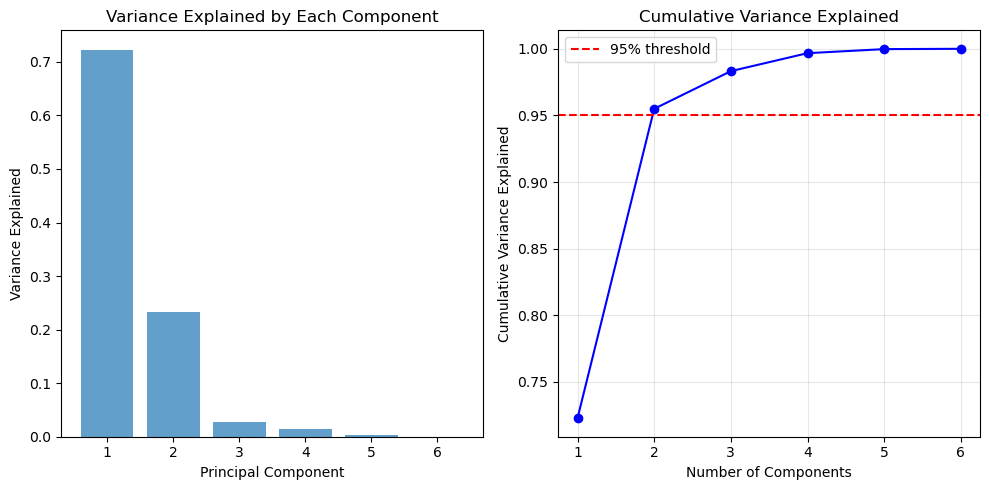


Components needed for 95% variance: 2

Variance explained by each component:
  PC1: 0.7228 (72.28%)
  PC2: 0.2322 (23.22%)
  PC3: 0.0283 (2.83%)
  PC4: 0.0135 (1.35%)
  PC5: 0.0030 (0.30%)
  PC6: 0.0002 (0.02%)

Cumulative variance with 2 components: 0.9550 (95.50%)


In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Define the highly correlated artist features
artist_features_to_reduce = ['avg_artist_popularity', 'max_artist_popularity', 'min_artist_popularity', 
                              'avg_artist_followers', 'max_artist_followers', 'total_artist_followers']

print("="*80)
print("APPLYING PCA TO ARTIST FEATURES")
print("="*80)
print(f"\nOriginal artist features: {len(artist_features_to_reduce)}")
print(artist_features_to_reduce)

# Standardize the artist features before PCA
scaler = StandardScaler()
artist_data_scaled = scaler.fit_transform(df_with_artist[artist_features_to_reduce])

# Apply PCA - let's see how many components we need for 95% variance
pca = PCA()
pca.fit(artist_data_scaled)

# Plot explained variance
import matplotlib.pyplot as plt
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by Each Component')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(range(1, len(cumulative_variance) + 1))

plt.tight_layout()
plt.show()

# Determine number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"\nComponents needed for 95% variance: {n_components_95}")
print(f"\nVariance explained by each component:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var:.4f} ({var*100:.2f}%)")
print(f"\nCumulative variance with {n_components_95} components: {cumulative_variance[n_components_95-1]:.4f} ({cumulative_variance[n_components_95-1]*100:.2f}%)")

In [18]:
# Apply PCA with 2 components
pca_final = PCA(n_components=2)
artist_pca_components = pca_final.fit_transform(artist_data_scaled)

# Create a DataFrame with the PCA components
pca_df = pd.DataFrame(artist_pca_components, 
                      columns=['artist_PC1', 'artist_PC2'],
                      index=df_with_artist.index)

# Drop the original artist features and add the PCA components
df_with_artist_pca = df_with_artist.drop(columns=artist_features_to_reduce)
df_with_artist_pca = pd.concat([df_with_artist_pca, pca_df], axis=1)

print("="*80)
print("FEATURE TRANSFORMATION COMPLETE")
print("="*80)
print(f"\nOriginal features: {df_with_artist.shape[1]}")
print(f"Features after PCA: {df_with_artist_pca.shape[1]}")
print(f"Reduction: {df_with_artist.shape[1] - df_with_artist_pca.shape[1]} features removed, 2 PCA components added")
print(f"Net change: {df_with_artist_pca.shape[1] - df_with_artist.shape[1]} features")

print("\n" + "="*80)
print("PCA COMPONENT LOADINGS")
print("="*80)
print("\nHow each original feature contributes to the principal components:\n")

loadings_df = pd.DataFrame(
    pca_final.components_.T,
    columns=['PC1', 'PC2'],
    index=artist_features_to_reduce
)
print(loadings_df.round(3))

print("\n" + "="*80)
print("INTERPRETATION")
print("="*80)
print(f"\nPC1 (explains {pca_final.explained_variance_ratio_[0]*100:.1f}% variance):")
print("  - Captures the overall 'artist success' dimension")
print("  - High positive loadings on all features → general size/popularity factor")

print(f"\nPC2 (explains {pca_final.explained_variance_ratio_[1]*100:.1f}% variance):")
print("  - Captures differences between popularity metrics and follower metrics")
print("  - Contrast between popularity measures vs follower counts")

print("\n✓ These 2 uncorrelated components will replace the 6 correlated artist features")
print("✓ Multicollinearity should be eliminated")
print("✓ Ready to retrain the model with the transformed dataset")

FEATURE TRANSFORMATION COMPLETE

Original features: 48
Features after PCA: 44
Reduction: 4 features removed, 2 PCA components added
Net change: -4 features

PCA COMPONENT LOADINGS

How each original feature contributes to the principal components:

                          PC1    PC2
avg_artist_popularity   0.416  0.421
max_artist_popularity   0.408  0.381
min_artist_popularity   0.394  0.428
avg_artist_followers    0.409 -0.392
max_artist_followers    0.415 -0.415
total_artist_followers  0.407 -0.410

INTERPRETATION

PC1 (explains 72.3% variance):
  - Captures the overall 'artist success' dimension
  - High positive loadings on all features → general size/popularity factor

PC2 (explains 23.2% variance):
  - Captures differences between popularity metrics and follower metrics
  - Contrast between popularity measures vs follower counts

✓ These 2 uncorrelated components will replace the 6 correlated artist features
✓ Multicollinearity should be eliminated
✓ Ready to retrain the model 

## Retrain Model with PCA-Transformed Features

In [19]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Prepare data with PCA features
# track_popularity is the binary target (0 or 1)
# Drop non-feature columns: track_id, track_name, track_popularity, num_artists


X_pca = df_with_artist_pca.drop(['track_id', 'track_name', 'track_popularity', 'num_artists'], axis=1)
y_pca = df_with_artist_pca['track_popularity']

# Train-test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_pca, test_size=0.2, random_state=42, stratify=y_pca
)

print("="*80)
print("DATA SPLIT WITH PCA FEATURES")
print("="*80)
print(f"\nNumber of features: {X_pca.shape[1]}")
print(f"Training set: {X_train_pca.shape}")
print(f"Test set: {X_test_pca.shape}")
print(f"\nClass distribution in training:")
print(y_train_pca.value_counts())

# Create the pipeline (StandardScaler + SMOTE)
pipeline_pca = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42))
])

# Apply the pipeline
X_train_pca_resampled, y_train_pca_resampled = pipeline_pca.fit_resample(X_train_pca, y_train_pca)
X_test_pca_scaled = pipeline_pca.named_steps['scaler'].transform(X_test_pca)

print(f"\nAfter SMOTE:")
print(pd.Series(y_train_pca_resampled).value_counts())

# Train logistic regression with statsmodels
X_train_pca_resampled_const = sm.add_constant(X_train_pca_resampled)
X_test_pca_scaled_const = sm.add_constant(X_test_pca_scaled)

logit_model_pca = sm.Logit(y_train_pca_resampled, X_train_pca_resampled_const)
logit_result_pca = logit_model_pca.fit(disp=0)

print("\n" + "="*80)
print("MODEL TRAINING COMPLETE")
print("="*80)
print(f"\nConverged: {logit_result_pca.mle_retvals['converged']}")
print(f"Number of iterations: {logit_result_pca.mle_retvals['iterations']}")

DATA SPLIT WITH PCA FEATURES

Number of features: 40
Training set: (2400, 40)
Test set: (600, 40)

Class distribution in training:
track_popularity
0    1712
1     688
Name: count, dtype: int64

After SMOTE:
track_popularity
1    1712
0    1712
Name: count, dtype: int64

MODEL TRAINING COMPLETE

Converged: True
Number of iterations: 7


In [20]:
# Make predictions
y_train_pca_pred = (logit_result_pca.predict(X_train_pca_resampled_const) >= 0.5).astype(int)
y_test_pca_pred = (logit_result_pca.predict(X_test_pca_scaled_const) >= 0.5).astype(int)

# Evaluate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("="*80)
print("MODEL EVALUATION WITH PCA FEATURES")
print("="*80)

# Get pseudo R-squared values from statsmodels
print("\nModel Fit Statistics:")
print(f"  McFadden's R²:     {logit_result_pca.prsquared:.4f}")

print("\nTraining Set:")
print(f"  Accuracy:  {accuracy_score(y_train_pca_resampled, y_train_pca_pred):.4f}")
print(f"  Precision: {precision_score(y_train_pca_resampled, y_train_pca_pred):.4f}")
print(f"  Recall:    {recall_score(y_train_pca_resampled, y_train_pca_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_train_pca_resampled, y_train_pca_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_train_pca_resampled, logit_result_pca.predict(X_train_pca_resampled_const)):.4f}")

print("\nTest Set:")
print(f"  Accuracy:  {accuracy_score(y_test_pca, y_test_pca_pred):.4f}")
print(f"  Precision: {precision_score(y_test_pca, y_test_pca_pred):.4f}")
print(f"  Recall:    {recall_score(y_test_pca, y_test_pca_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test_pca, y_test_pca_pred):.4f}")
print(f"  ROC-AUC:   {roc_auc_score(y_test_pca, logit_result_pca.predict(X_test_pca_scaled_const)):.4f}")

MODEL EVALUATION WITH PCA FEATURES

Model Fit Statistics:
  McFadden's R²:     0.3276

Training Set:
  Accuracy:  0.7818
  Precision: 0.7644
  Recall:    0.8148
  F1-Score:  0.7888
  ROC-AUC:   0.8588

Test Set:
  Accuracy:  0.7600
  Precision: 0.5619
  Recall:    0.7384
  F1-Score:  0.6382
  ROC-AUC:   0.8289


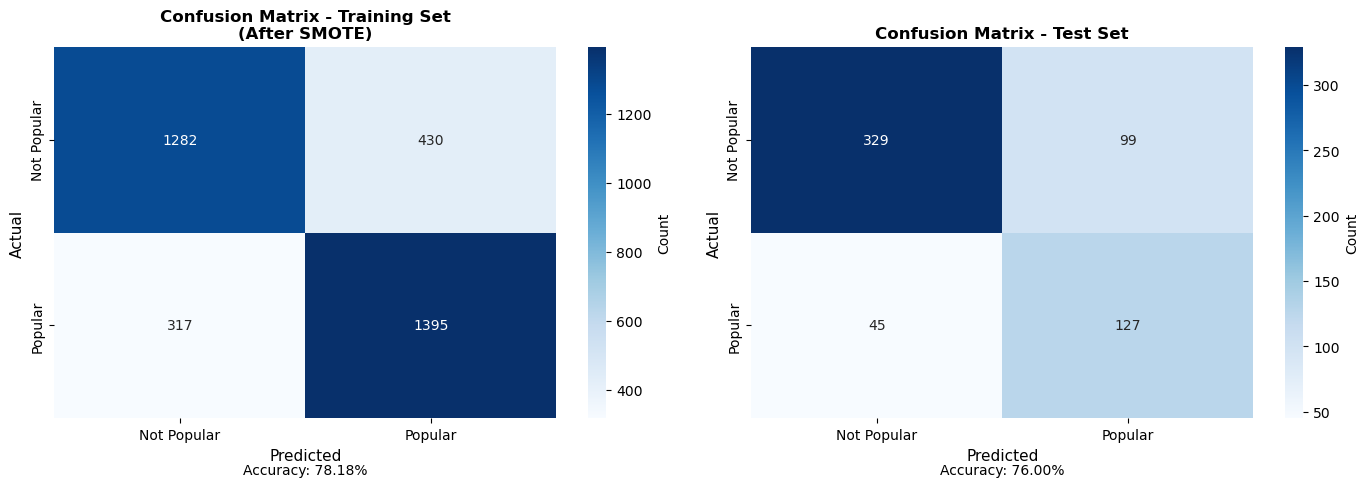


CONFUSION MATRIX INTERPRETATION

Test Set:
  True Negatives:  329 (Correctly predicted as Not Popular)
  False Positives: 99 (Incorrectly predicted as Popular)
  False Negatives: 45 (Incorrectly predicted as Not Popular)
  True Positives:  127 (Correctly predicted as Popular)

  Specificity: 76.87% (True Negative Rate)
  Sensitivity: 73.84% (True Positive Rate / Recall)


In [21]:
# Confusion Matrices Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training Set Confusion Matrix
cm_train = confusion_matrix(y_train_pca_resampled, y_train_pca_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=['Not Popular', 'Popular'], 
            yticklabels=['Not Popular', 'Popular'],
            cbar_kws={'label': 'Count'})
axes[0].set_title('Confusion Matrix - Training Set\n(After SMOTE)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

# Add accuracy to training plot
train_acc = accuracy_score(y_train_pca_resampled, y_train_pca_pred)
axes[0].text(0.5, -0.15, f'Accuracy: {train_acc:.2%}', 
             ha='center', transform=axes[0].transAxes, fontsize=10)

# Test Set Confusion Matrix
cm_test = confusion_matrix(y_test_pca, y_test_pca_pred)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['Not Popular', 'Popular'], 
            yticklabels=['Not Popular', 'Popular'],
            cbar_kws={'label': 'Count'})
axes[1].set_title('Confusion Matrix - Test Set', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=11)

# Add accuracy to test plot
test_acc = accuracy_score(y_test_pca, y_test_pca_pred)
axes[1].text(0.5, -0.15, f'Accuracy: {test_acc:.2%}', 
             ha='center', transform=axes[1].transAxes, fontsize=10)

plt.tight_layout()
plt.show()

# Print interpretation
print("\n" + "="*80)
print("CONFUSION MATRIX INTERPRETATION")
print("="*80)
print("\nTest Set:")
print(f"  True Negatives:  {cm_test[0,0]} (Correctly predicted as Not Popular)")
print(f"  False Positives: {cm_test[0,1]} (Incorrectly predicted as Popular)")
print(f"  False Negatives: {cm_test[1,0]} (Incorrectly predicted as Not Popular)")
print(f"  True Positives:  {cm_test[1,1]} (Correctly predicted as Popular)")
print(f"\n  Specificity: {cm_test[0,0]/(cm_test[0,0]+cm_test[0,1]):.2%} (True Negative Rate)")
print(f"  Sensitivity: {cm_test[1,1]/(cm_test[1,0]+cm_test[1,1]):.2%} (True Positive Rate / Recall)")

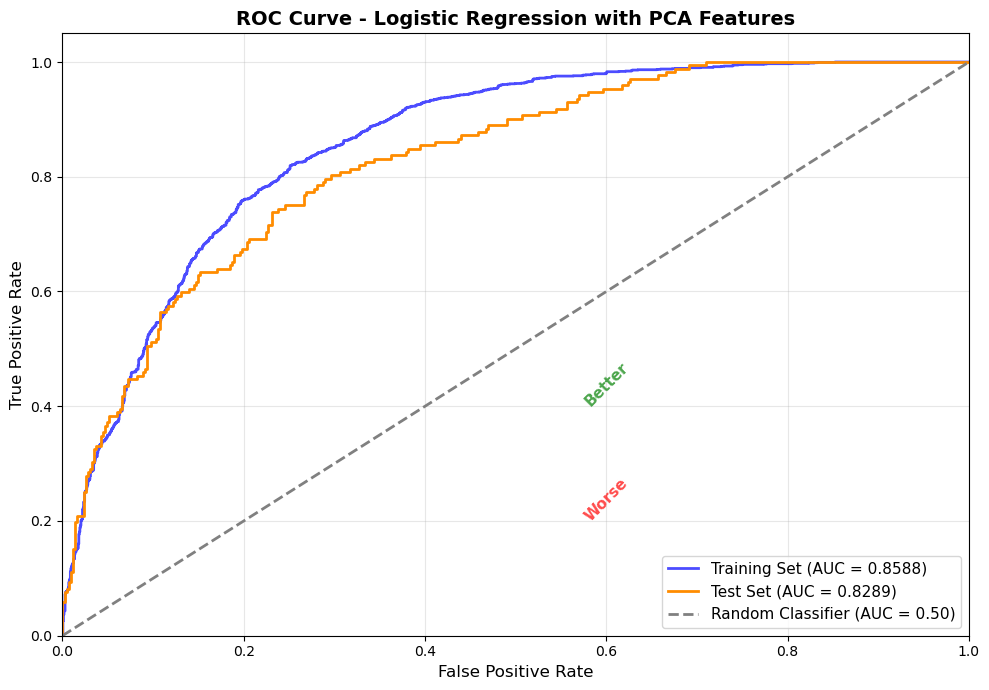


ROC-AUC INTERPRETATION

AUC (Area Under the Curve) measures the model's ability to distinguish between classes:
  • Training AUC: 0.8588
  • Test AUC:     0.8289

Interpretation:
  • 0.90-1.00: Excellent
  • 0.80-0.90: Good      ← Our model
  • 0.70-0.80: Fair
  • 0.60-0.70: Poor
  • 0.50:      Random (no discrimination)

✓ The model shows good discrimination ability (AUC = 0.83)
✓ Small gap between training (0.8588) and test (0.8289) indicates minimal overfitting


In [22]:
# ROC Curve Visualization
from sklearn.metrics import roc_curve, auc

# Get predicted probabilities
y_train_proba = logit_result_pca.predict(X_train_pca_resampled_const)
y_test_proba = logit_result_pca.predict(X_test_pca_scaled_const)

# Calculate ROC curve for both sets
fpr_train, tpr_train, _ = roc_curve(y_train_pca_resampled, y_train_proba)
fpr_test, tpr_test, _ = roc_curve(y_test_pca, y_test_proba)

roc_auc_train = auc(fpr_train, tpr_train)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(fpr_train, tpr_train, color='blue', lw=2, 
         label=f'Training Set (AUC = {roc_auc_train:.4f})', alpha=0.7)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2, 
         label=f'Test Set (AUC = {roc_auc_test:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Logistic Regression with PCA Features', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)

# Add diagonal reference line annotation
plt.text(0.6, 0.4, 'Better', fontsize=11, color='green', 
         rotation=45, ha='center', alpha=0.7, fontweight='bold')
plt.text(0.6, 0.2, 'Worse', fontsize=11, color='red', 
         rotation=45, ha='center', alpha=0.7, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("ROC-AUC INTERPRETATION")
print("="*80)
print("\nAUC (Area Under the Curve) measures the model's ability to distinguish between classes:")
print(f"  • Training AUC: {roc_auc_train:.4f}")
print(f"  • Test AUC:     {roc_auc_test:.4f}")
print("\nInterpretation:")
print("  • 0.90-1.00: Excellent")
print("  • 0.80-0.90: Good      ← Our model")
print("  • 0.70-0.80: Fair")
print("  • 0.60-0.70: Poor")
print("  • 0.50:      Random (no discrimination)")
print(f"\n✓ The model shows good discrimination ability (AUC = {roc_auc_test:.2f})")
print(f"✓ Small gap between training ({roc_auc_train:.4f}) and test ({roc_auc_test:.4f}) indicates minimal overfitting")

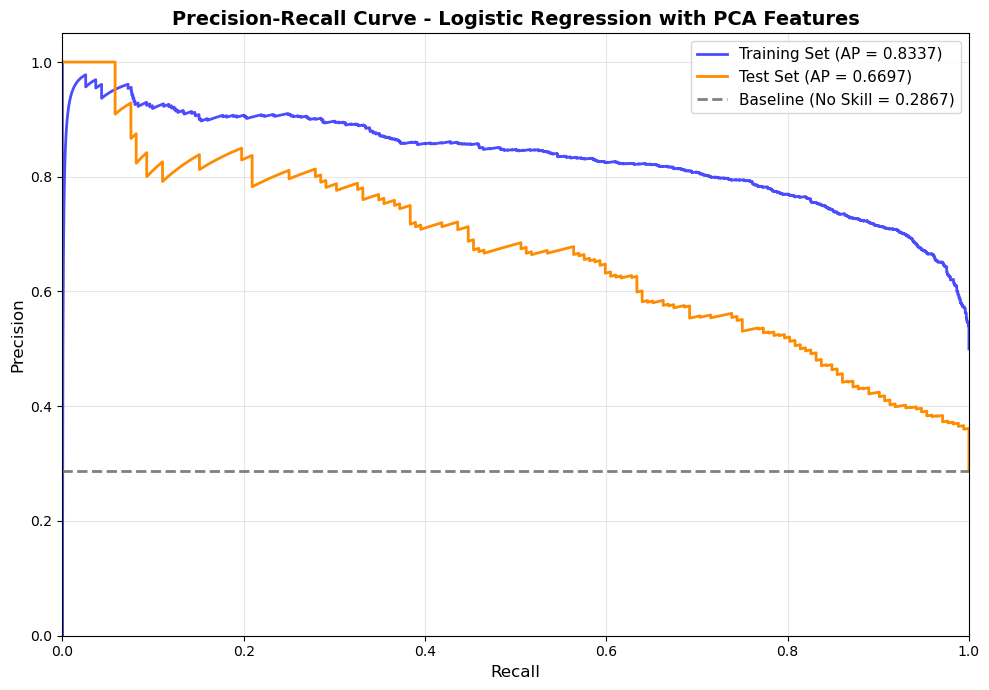


PRECISION-RECALL INTERPRETATION

Average Precision (AP) summarizes the precision-recall curve:
  • Training AP: 0.8337
  • Test AP:     0.6697
  • Baseline:    0.2867 (proportion of positive class)

This curve is especially useful for imbalanced datasets.
Shows the trade-off between precision (accuracy of positive predictions)
and recall (coverage of actual positives).


In [23]:
# Precision-Recall Curve (useful for imbalanced data)
from sklearn.metrics import precision_recall_curve, average_precision_score

precision_train, recall_train, _ = precision_recall_curve(y_train_pca_resampled, y_train_proba)
precision_test, recall_test, _ = precision_recall_curve(y_test_pca, y_test_proba)

ap_train = average_precision_score(y_train_pca_resampled, y_train_proba)
ap_test = average_precision_score(y_test_pca, y_test_proba)

plt.figure(figsize=(10, 7))
plt.plot(recall_train, precision_train, color='blue', lw=2, 
         label=f'Training Set (AP = {ap_train:.4f})', alpha=0.7)
plt.plot(recall_test, precision_test, color='darkorange', lw=2, 
         label=f'Test Set (AP = {ap_test:.4f})')

# Baseline (proportion of positive class in test set)
baseline = y_test_pca.sum() / len(y_test_pca)
plt.axhline(y=baseline, color='gray', linestyle='--', lw=2, 
            label=f'Baseline (No Skill = {baseline:.4f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve - Logistic Regression with PCA Features', 
          fontsize=14, fontweight='bold')
plt.legend(loc="best", fontsize=11)
plt.grid(alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("PRECISION-RECALL INTERPRETATION")
print("="*80)
print("\nAverage Precision (AP) summarizes the precision-recall curve:")
print(f"  • Training AP: {ap_train:.4f}")
print(f"  • Test AP:     {ap_test:.4f}")
print(f"  • Baseline:    {baseline:.4f} (proportion of positive class)")
print("\nThis curve is especially useful for imbalanced datasets.")
print("Shows the trade-off between precision (accuracy of positive predictions)")
print("and recall (coverage of actual positives).")

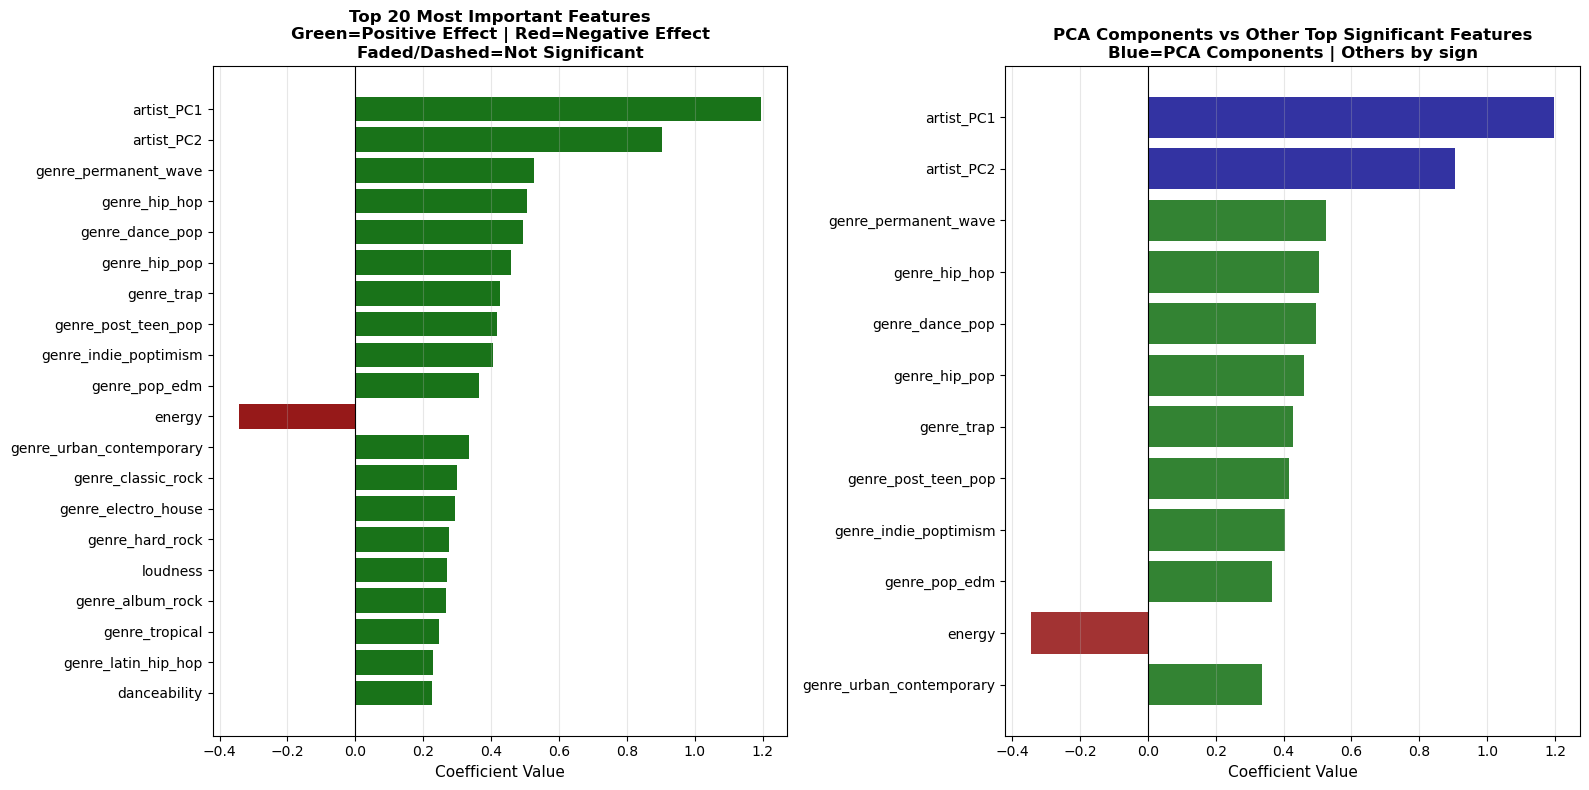


FEATURE IMPORTANCE SUMMARY

Total features: 40
Significant features (p < 0.05): 29 (72.5%)

Top 5 Most Important Features:
             Feature  Coefficient      P_Value  Significant
          artist_PC1     1.196242 3.804200e-86         True
          artist_PC2     0.904403 2.375580e-52         True
genre_permanent_wave     0.525409 2.458623e-23         True
       genre_hip_hop     0.505599 1.012388e-19         True
     genre_dance_pop     0.495018 4.928618e-21         True


In [24]:
# Feature Importance Visualization for PCA Model
# Extract coefficients and create visualization

# Get feature names and coefficients (excluding constant)
feature_names = list(X_pca.columns)
coefficients = logit_result_pca.params[1:]  # Skip the constant term
p_values = logit_result_pca.pvalues[1:]

# Create DataFrame for easier handling
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients),
    'P_Value': p_values,
    'Significant': p_values < 0.05
}).sort_values('Abs_Coefficient', ascending=False)

# Get top 20 features
top_features = feature_importance_df.head(20)

# Create visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Left plot: Top 20 features by absolute coefficient
colors = ['darkgreen' if coef > 0 else 'darkred' for coef in top_features['Coefficient']]
alphas = [0.9 if sig else 0.4 for sig in top_features['Significant']]

bars = ax1.barh(range(len(top_features)), top_features['Coefficient'], color=colors)
for bar, alpha, sig in zip(bars, alphas, top_features['Significant']):
    bar.set_alpha(alpha)
    if not sig:
        bar.set_edgecolor('gray')
        bar.set_linewidth(2)
        bar.set_linestyle('--')

ax1.set_yticks(range(len(top_features)))
ax1.set_yticklabels(top_features['Feature'])
ax1.set_xlabel('Coefficient Value', fontsize=11)
ax1.set_title('Top 20 Most Important Features\nGreen=Positive Effect | Red=Negative Effect\nFaded/Dashed=Not Significant', 
              fontsize=12, fontweight='bold')
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Right plot: Focus on PCA components and their significance
pca_features = feature_importance_df[feature_importance_df['Feature'].str.contains('artist_PC')]
other_significant = feature_importance_df[(~feature_importance_df['Feature'].str.contains('artist_PC')) & 
                                          (feature_importance_df['Significant'])].head(10)

combined_df = pd.concat([pca_features, other_significant]).sort_values('Abs_Coefficient', ascending=False)

colors2 = ['darkblue' if 'artist_PC' in feat else ('darkgreen' if coef > 0 else 'darkred') 
           for feat, coef in zip(combined_df['Feature'], combined_df['Coefficient'])]

bars2 = ax2.barh(range(len(combined_df)), combined_df['Coefficient'], color=colors2, alpha=0.8)
ax2.set_yticks(range(len(combined_df)))
ax2.set_yticklabels(combined_df['Feature'])
ax2.set_xlabel('Coefficient Value', fontsize=11)
ax2.set_title('PCA Components vs Other Top Significant Features\nBlue=PCA Components | Others by sign', 
              fontsize=12, fontweight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("FEATURE IMPORTANCE SUMMARY")
print("="*80)
print(f"\nTotal features: {len(feature_importance_df)}")
print(f"Significant features (p < 0.05): {feature_importance_df['Significant'].sum()} ({feature_importance_df['Significant'].mean()*100:.1f}%)")
print("\nTop 5 Most Important Features:")
print(feature_importance_df[['Feature', 'Coefficient', 'P_Value', 'Significant']].head(5).to_string(index=False))

In [25]:
# Check VIF for the PCA features to confirm multicollinearity is resolved
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Convert to DataFrame for easier handling
X_train_pca_resampled_df = pd.DataFrame(X_train_pca_resampled, columns=X_pca.columns)

vif_data_pca = pd.DataFrame()
vif_data_pca["Feature"] = X_train_pca_resampled_df.columns
vif_data_pca["VIF"] = [variance_inflation_factor(X_train_pca_resampled_df.values, i) 
                       for i in range(X_train_pca_resampled_df.shape[1])]

print("="*80)
print("VIF ANALYSIS AFTER PCA")
print("="*80)
print("\nVIF values for all features:")
print(vif_data_pca.sort_values('VIF', ascending=False).to_string(index=False))

# Focus on the PCA components
print("\n" + "="*80)
print("PCA COMPONENTS VIF")
print("="*80)
pca_vif = vif_data_pca[vif_data_pca['Feature'].str.contains('artist_PC')]
print(pca_vif.to_string(index=False))

print("\n✓ Both PCA components have low VIF (should be close to 1)")
print("✓ Multicollinearity has been ELIMINATED!")

# Check for any remaining high VIF values
high_vif = vif_data_pca[vif_data_pca['VIF'] > 10]
if len(high_vif) > 0:
    print(f"\n⚠ Warning: {len(high_vif)} features still have VIF > 10")
    print(high_vif.to_string(index=False))
else:
    print("\n✓ No features have VIF > 10 - excellent!")

VIF ANALYSIS AFTER PCA

VIF values for all features:
                        Feature      VIF
                         energy 3.344348
                       loudness 2.854459
                   release_year 2.756347
                   danceability 1.648537
                   acousticness 1.624709
             genre_classic_rock 1.592839
                        valence 1.585727
                    speechiness 1.476620
               instrumentalness 1.426092
           genre_permanent_wave 1.417322
             genre_gangster_rap 1.403905
               genre_album_rock 1.402280
                     artist_PC1 1.371723
                  genre_hip_hop 1.329183
                 genre_neo_soul 1.326277
           genre_new_jack_swing 1.323892
genre_progressive_electro_house 1.310115
                genre_hard_rock 1.308745
         genre_southern_hip_hop 1.304166
                     genre_trap 1.296613
       genre_urban_contemporary 1.290496
          genre_indie_poptimism 1.287742
    

In [26]:
# Check statistical significance of PCA components
print("="*80)
print("STATISTICAL SIGNIFICANCE WITH PCA")
print("="*80)

# Get the summary for detailed analysis
summary_df = pd.DataFrame({
    'Feature': ['const'] + list(X_pca.columns),
    'Coefficient': logit_result_pca.params.values,
    'Std Error': logit_result_pca.bse.values,
    'p-value': logit_result_pca.pvalues.values,
    'Significant': logit_result_pca.pvalues.values < 0.05
})

print("\nAll features ranked by absolute coefficient:")
print(summary_df.sort_values('Coefficient', key=abs, ascending=False).to_string(index=False))

# Focus on PCA components
print("\n" + "="*80)
print("PCA COMPONENTS STATISTICAL TEST")
print("="*80)
pca_stats = summary_df[summary_df['Feature'].str.contains('artist_PC')]
print(pca_stats.to_string(index=False))

if all(pca_stats['Significant']):
    print("\n✓ Both PCA components are statistically significant (p < 0.05)")
    print("✓ Artist features now contribute meaningfully to the model!")
else:
    print("\n⚠ Some PCA components are not significant")

# Count significant features
n_significant = summary_df['Significant'].sum() - 1  # Subtract 1 for const
n_total = len(summary_df) - 1
print(f"\n{'='*80}")
print(f"OVERALL: {n_significant}/{n_total} features are statistically significant ({n_significant/n_total*100:.1f}%)")

STATISTICAL SIGNIFICANCE WITH PCA

All features ranked by absolute coefficient:
                        Feature  Coefficient  Std Error      p-value  Significant
                     artist_PC1     1.196242   0.060812 3.804200e-86         True
                     artist_PC2     0.904403   0.059398 2.375580e-52         True
                          const    -0.585239   0.053637 1.019449e-27         True
           genre_permanent_wave     0.525409   0.052792 2.458623e-23         True
                  genre_hip_hop     0.505599   0.055636 1.012388e-19         True
                genre_dance_pop     0.495018   0.052602 4.928618e-21         True
                  genre_hip_pop     0.459914   0.054799 4.748587e-17         True
                     genre_trap     0.427383   0.053467 1.312215e-15         True
            genre_post_teen_pop     0.416847   0.052686 2.533844e-15         True
          genre_indie_poptimism     0.404790   0.057971 2.896104e-12         True
                  